In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import numpy as np
from matplotlib import pyplot as plt
import robot_room as robot
from histogram_filters import plot_distribution, convolve, get_room_observation_likelihood, \
        update, run_histogram_filter, get_hist_circular_mean_var, generate_sample, plot_estimations,\
        get_walking_noise_perfect_1, get_walking_noise_example_1
import draw_hmm as hmm
from IPython import display
%matplotlib inline

# Histogram Filters
Estimates the state of a system
- Non parametric (Full histogram), parametric example: mean, variance, etc
- Multimodal
- Google uses it to locate self-driven car

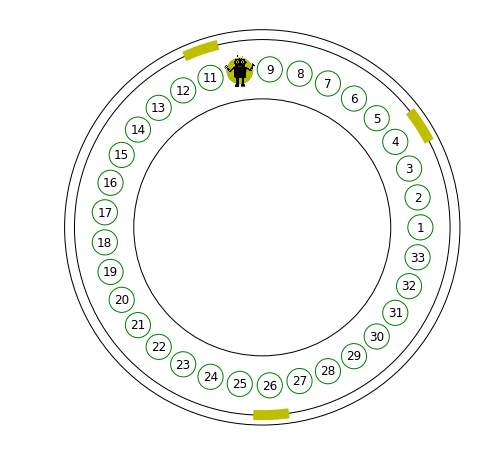

In [3]:
doors = np.array([4, 11, 26])
N = 33
robot.plot_robot_room(loc = 10, N=N, doors = doors)

# Perfect Sensor Model (Not walking)
## The model
$S_k = S_{k-1}$ Not walking

$X_k$ and $S_k$ are correlated

**$P(X = $ "door" | $S_k =$ "infront door" $)$ $= 1$** 

**$P(X = $ "wall" | $S_k =$ "infront wall" $)$ $= 1$** 


## Where am I?

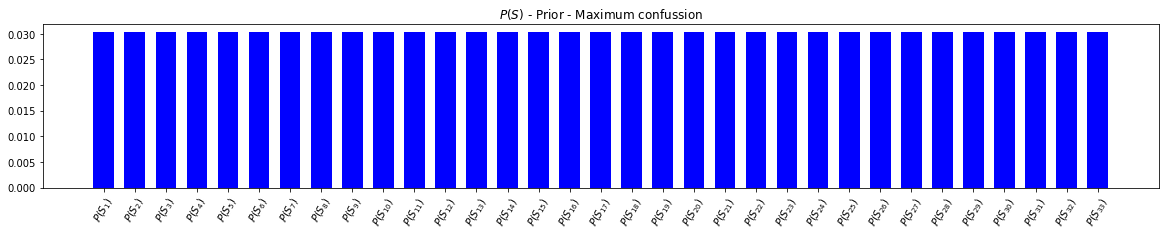

In [4]:
p = np.ones(N)/N
str_indexes_prior =  ['$P(S_{%s})$'%int(i+1) for i in range(N)]
plot_distribution(p, title = '$P(S)$ - Prior - Maximum confussion', str_indexes= str_indexes_prior, 
                         rotation = 60)

## Likelihoods - $\mathcal{L}(S_k|X=X_0)$ = $P(X=X_0|S_k)$ 
The likelihood can add more than one:
https://www.youtube.com/watch?v=sm60vapz2jQ

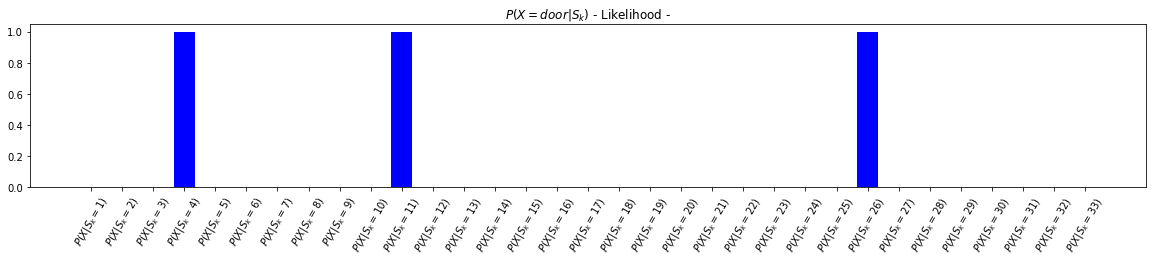

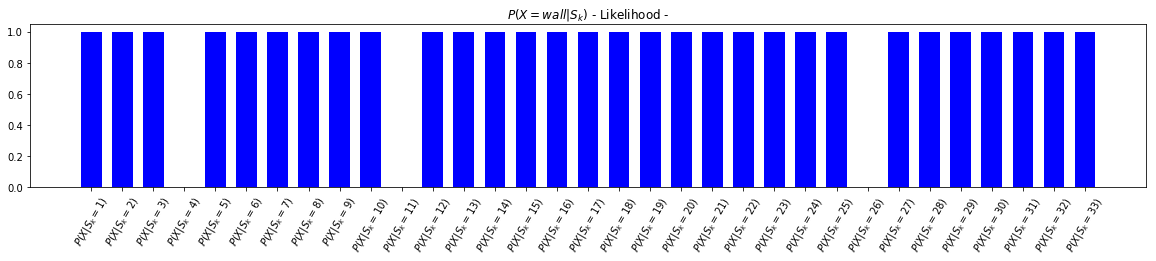

In [39]:
likelihood_perfect_sensor={}
likelihood_perfect_sensor['door'] = np.zeros(N)
likelihood_perfect_sensor['door'][doors-1] = 1
likelihood_perfect_sensor['wall'] = 1-likelihood_perfect_sensor['door']
str_indexes_likelihood =  ['$P(X|S_{k}=%s)$'%int(i+1) for i in range(N)]
plot_distribution(likelihood_perfect_sensor['door'], title = '$P(X=door|S_k)$ - Likelihood -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)
plot_distribution(likelihood_perfect_sensor['wall'],  title = '$P(X=wall|S_k)$ - Likelihood -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)

## Generative model (HMM)

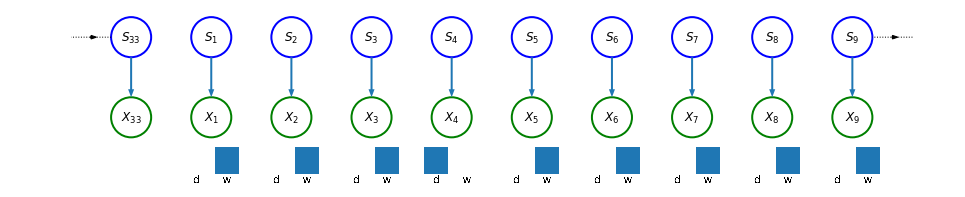

In [58]:
images_map_perfect = hmm.get_image_map_sensor(likelihood_perfect_sensor['door'])
hmm.plot_basic_hmm_model(N = N, N_states_visible = 10, circular = True, stay_step_prob = 0, 
                         one_step_prob = 0.0, two_step_prob = 0, images_map = images_map_perfect)

## Sense

Bayes therorem

$P(S_k|X) = \frac{P(X|S_k)P(S_K)}{P(X)}$

$P(X) = \sum_i{P(X,S_i)} = \sum_i{P(X|S_i)P(S_i)}$

No suele ser necesario calcular P(X). Simplemente normalizamos

## Posteriors - not normalized
$P(S_k|X) = \alpha{P(X|S_k)P(S_K)}$

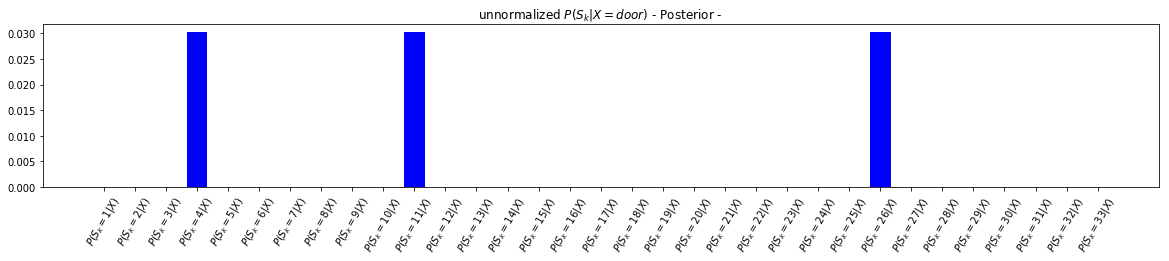

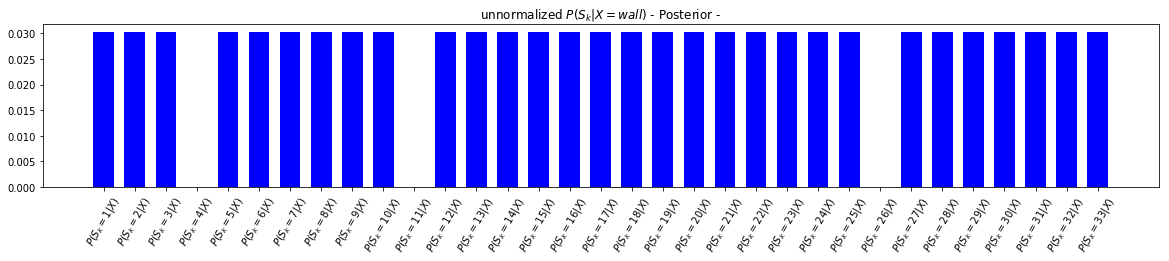

In [40]:
str_indexes_posterior =  ['$P(S_k=%s|X)$'%int(i+1) for i in range(len(p))]
plot_distribution(likelihood_perfect_sensor['door']*p, title = 'unnormalized $P(S_k|X=door)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
plot_distribution(likelihood_perfect_sensor['wall']*p,  title = 'unnormalized $P(S_k|X=wall)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)

## Normalized posterior

In [8]:
def update(p, X, likelihood):
    # p: prior probability
    # X: Measurement, can be door or wall
    # posterior not normalized
    posterior = likelihood[X]*p
    # Normalize it
    normalized = posterior/posterior.sum()
    return normalized

# Real Sensor Model (Not walking)
## The model
$S_k = S_{k-1}$ Not walking

$X_k$ and $S_k$ are correlated


**$P(X = $ "door" | $S =$ "infront door" $)$ $= 0.9$** and **$P(X = $ "wall" | $S =$ "infront door" $)$ $= 0.1$**

**$P(X = $ "door" | $S =$ "1 away from door" $)$ $ = 0.75$** and **$P(X = $ "wall" | $S =$ "1 away from door" $)$ $ = 0.25$**

**$P(X = $ "door" | $S =$ "2 away from door" $)$ $ = 0.2$** and **$P(X = $ "wall" | $S =$ "2 away from door" $)$ $ = 0.8$**

**$P(X = $ "door" | $S =$ "other" $)$ $ = 0.05$** and **$P(X = $ "wall" | $S =$ "other" $)$ $ = 0.95$**

## Likelihoods

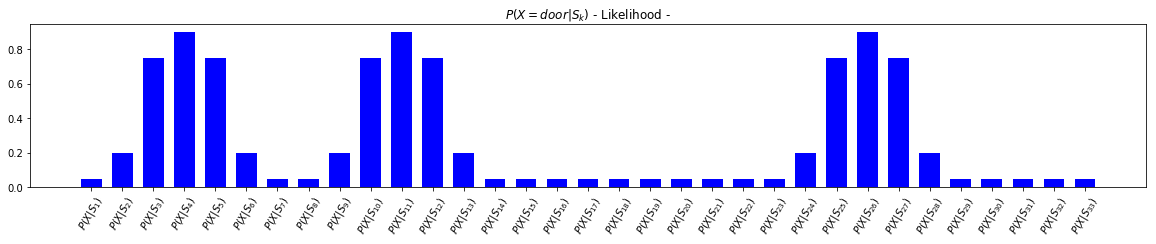

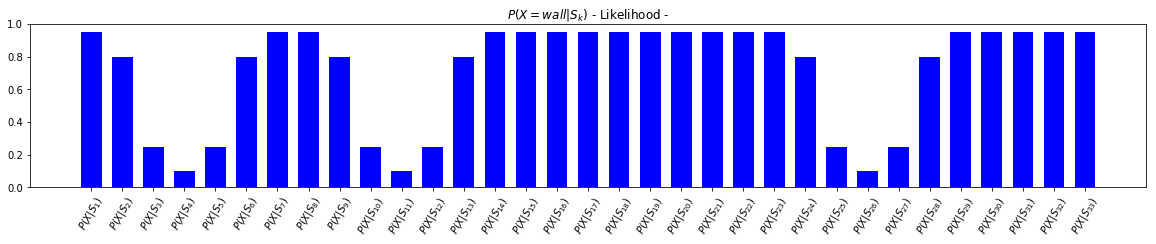

In [9]:
pulse = np.array([0.2, 0.75, 0.9, 0.75, 0.2])
noise = 0.05
likelihood = get_room_observation_likelihood(N = N, doors = doors, pulse = pulse, noise = noise)
plot_distribution(likelihood['door'], title = '$P(X=door|S_k)$ - Likelihood -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)
plot_distribution(likelihood['wall'],  title = '$P(X=wall|S_k)$ - Likelihood -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)

## Generative model (HMM)

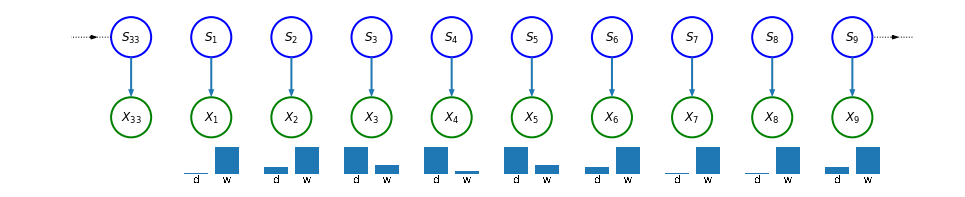

In [57]:
images_map = hmm.get_image_map_sensor(likelihood['door'])
hmm.plot_basic_hmm_model(N = N, N_states_visible = 10, circular = True, stay_step_prob = 0, 
                         one_step_prob = 0.0, two_step_prob = 0, figsize = (20,3), images_map = images_map)

## Multiple measurements
$P(S_{k}|X) = \alpha{P(X|S_k)P(S_{k-1}|X)}$

In [11]:
def do_measurements(p, measurements, likelihood, plot=True, title = '$P(S|X)$ - Posterior -'):
    # p: prior
    # measurements: list of measurements
    for measurement in measurements:
        p = update(p, measurement, likelihood)
        # The new update turns into the next prior
        
    if plot:
        str_indexes =  ['$P(S=%s|X)$'%int(i+1) for i in range(len(p))]
        plot_distribution(p, title = title, str_indexes= str_indexes, rotation = 50)
    return p

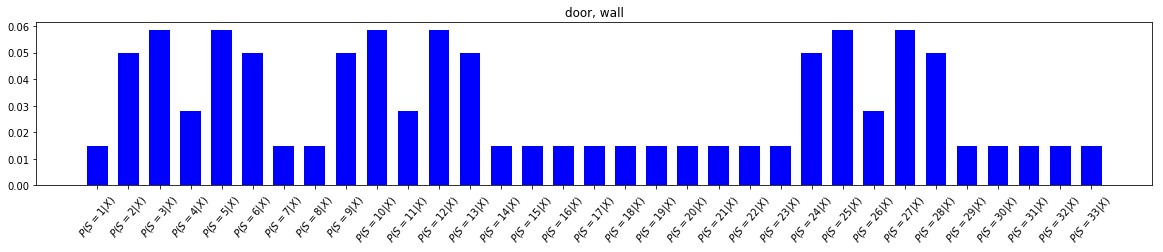

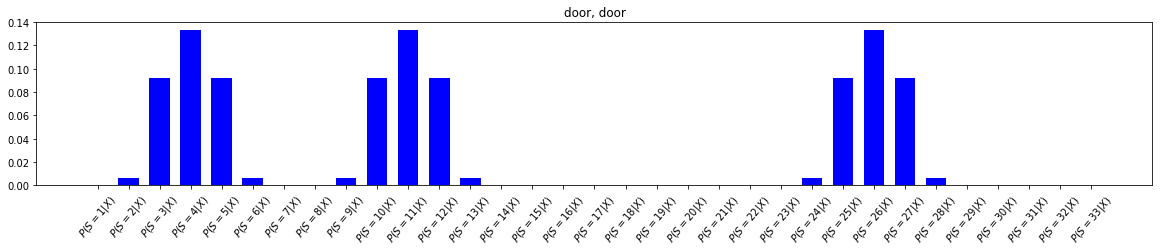

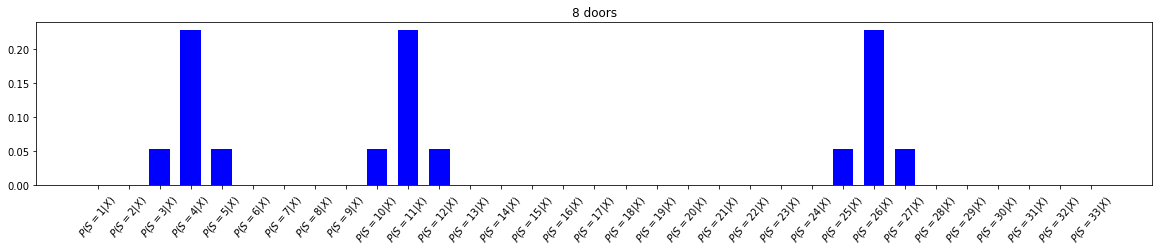

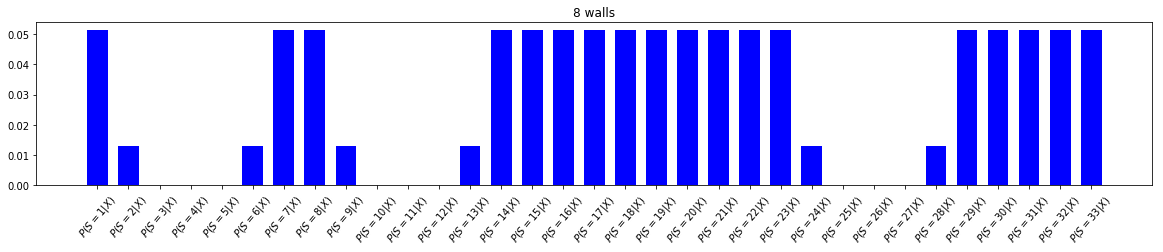

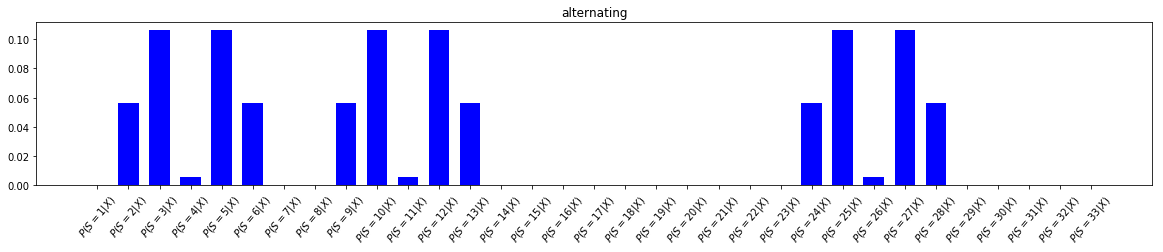

In [12]:
p = np.ones(N)/N
_ = do_measurements(p, ["door", "wall"], likelihood, title ='door, wall')
_ = do_measurements(p, ["door", "door"], likelihood, title ='door, door')
_ = do_measurements(p, ["door", "door", "door","door","door", "door","door","door"], likelihood, title ='8 doors')
_ = do_measurements(p, ["wall", "wall","wall","wall","wall", "wall","wall","wall"], likelihood, title ='8 walls')
_ = do_measurements(p, ["door", "wall","door","wall","door", "wall","door","wall"], likelihood, title ='alternating')

# Real Sensor and perfect walking Model 
## The model
$S_k = S_{k-1} + 1$ 

$X_k$ and $S_k$ are correlated


**$P(X = $ "door" | $S =$ "infront door" $)$ $= 0.9$** and **$P(X = $ "wall" | $S =$ "infront door" $)$ $= 0.1$**

**$P(X = $ "door" | $S =$ "1 away from door" $)$ $ = 0.75$** and **$P(X = $ "wall" | $S =$ "1 away from door" $)$ $ = 0.25$**

**$P(X = $ "door" | $S =$ "2 away from door" $)$ $ = 0.2$** and **$P(X = $ "wall" | $S =$ "2 away from door" $)$ $ = 0.8$**

**$P(X = $ "door" | $S =$ "other" $)$ $ = 0.05$** and **$P(X = $ "wall" | $S =$ "other" $)$ $ = 0.95$**

## Generative model (HMM)

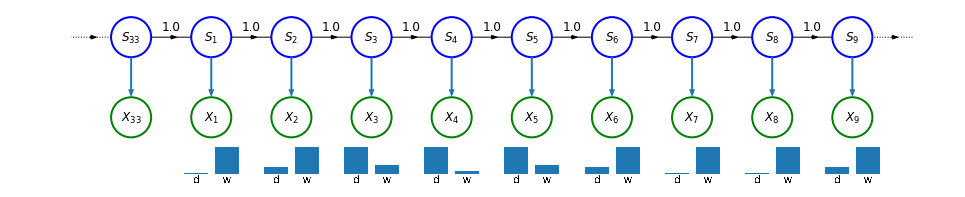

In [56]:
images_map = hmm.get_image_map_sensor(likelihood['door'])
hmm.plot_basic_hmm_model(N = N, N_states_visible = 10, circular = True, stay_step_prob = 0, 
                         one_step_prob = 1.0, two_step_prob = 0, figsize = (20,3), images_map = images_map)

[ 1.]
['wall', 'wall', 'door', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'door']
[{'wall': 93, 'door': 7}, {'wall': 80, 'door': 20}, {'door': 74, 'wall': 26}, {'door': 87, 'wall': 13}, {'door': 69, 'wall': 31}, {'door': 30, 'wall': 70}, {'wall': 88, 'door': 12}, {'wall': 93, 'door': 7}, {'wall': 78, 'door': 22}, {'door': 73, 'wall': 27}, {'door': 92, 'wall': 8}, {'door': 77, 'wall': 23}, {'wall': 82, 'door': 18}, {'wall': 90, 'door': 10}, {'wall': 94, 'door': 6}, {'wall': 98, 'door': 2}, {'wall': 92, 'door': 8}, {'wall': 93, 'door': 7}, {'wall': 95, 'door': 5}, {'door': 2, 'wall': 98}, {'wall': 94, 'door': 6}, {'wall': 95, 'door': 5}, {'door': 6, 'wall': 94}, {'wall': 79, 'door': 21}, {'wall': 33, 'door': 67}, {'door': 85, 'wall': 15}, {'door': 71, 'wall': 29}, {'wall': 76, 'door': 24}, {'wall': 96, 'door': 4}, {'wall': 92, 'door': 8}, {'wall': 97, 'door': 3}, {'wall': 99, 'door': 1}, {'wall': 98, 'door': 2}]


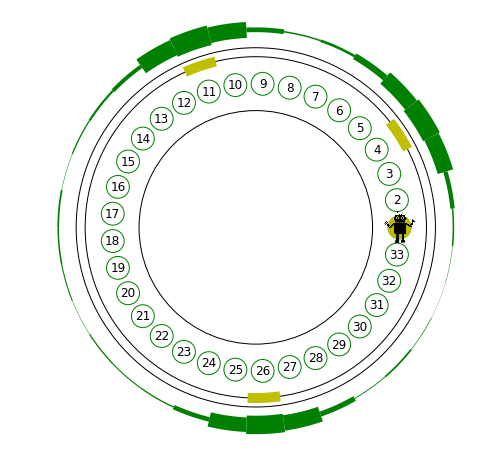

In [14]:
steps = 100*N
measurements, sample_stats, steps_stats, loc = generate_sample(likelihood, np.array([0,1]), steps = steps)
print(steps_stats)
print(measurements[:10])
print(sample_stats)
robot.plot_robot_room(loc = (steps%N)+1, N=N, doors = doors, sample_stats = sample_stats)

## Prediction

In [15]:
def predict_perfect(posterior):
    return np.roll(posterior,1)

## Two doors observed

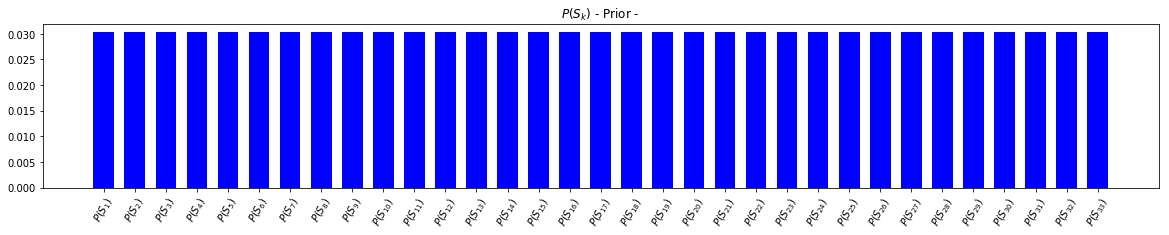

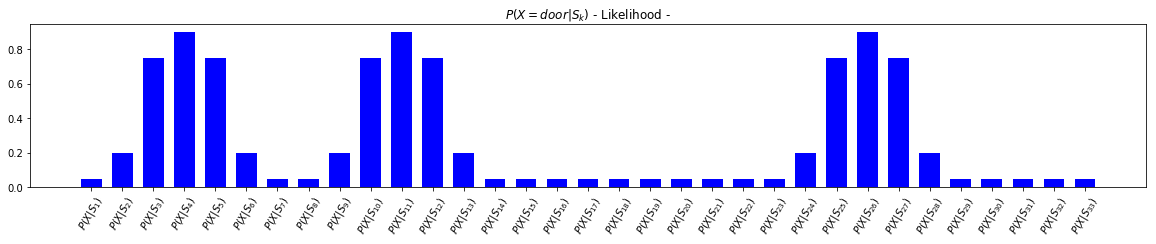

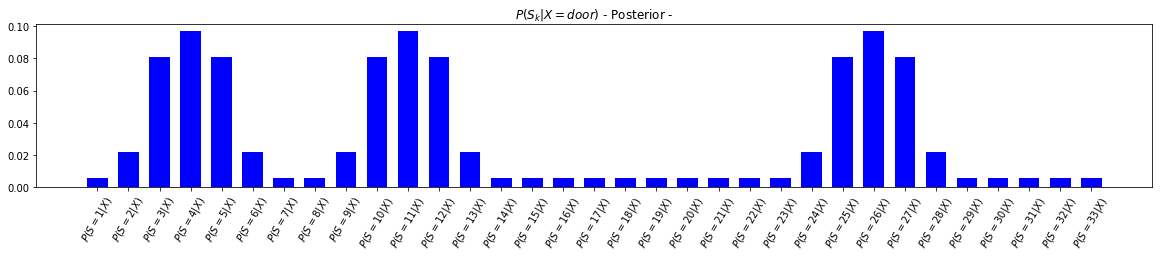

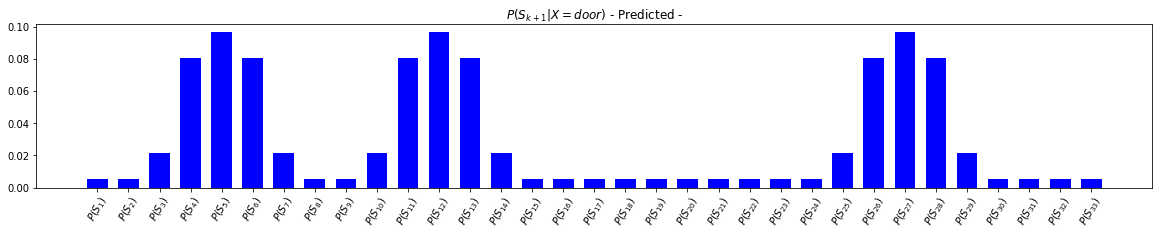

In [16]:
p = np.ones(N)/N
plot_distribution(p, title = '$P(S_k)$ - Prior -', 
                         str_indexes= str_indexes_prior, rotation = 60)
# Observo una puerta
X = 'door'
plot_distribution(likelihood[X], title = '$P(X=door|S_k)$ - Likelihood -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)
posterior = update(p, X, likelihood)
plot_distribution(posterior, title = '$P(S_k|X=door)$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
predicted_1 = predict_perfect(posterior)
plot_distribution(predicted_1, title = '$P(S_{k+1}|X=door)$ - Predicted -', 
                         str_indexes= str_indexes_prior, rotation = 60)

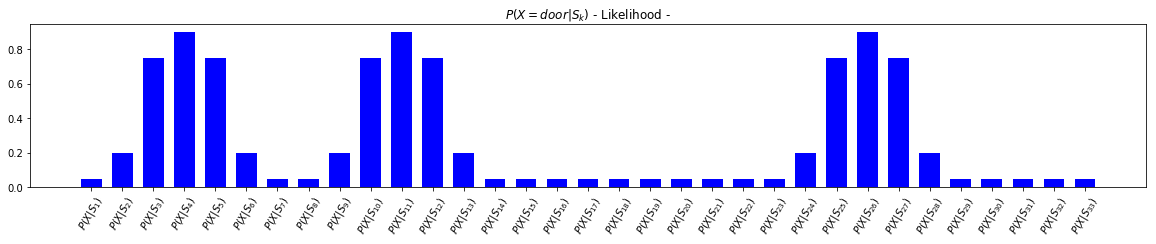

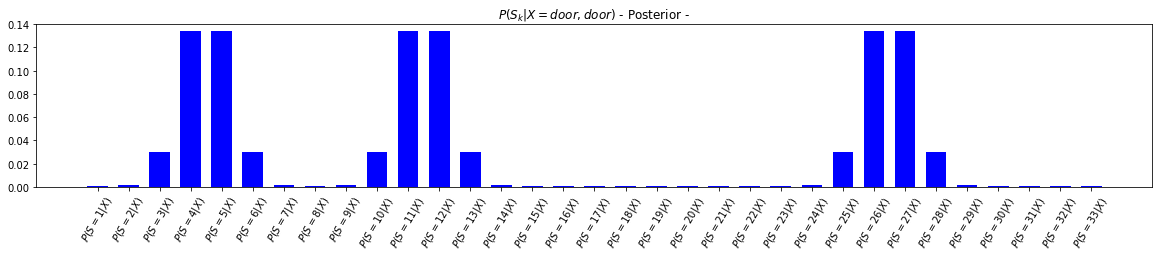

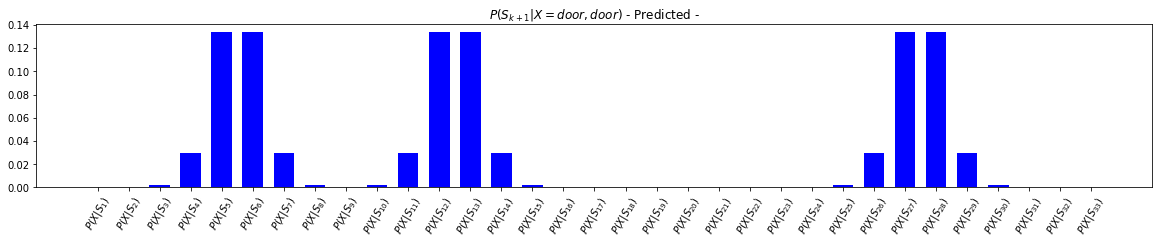

In [17]:
# Observe another door
plot_distribution(likelihood[X], title = '$P(X=door|S_k)$ - Likelihood -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)
posterior = update(predicted_1, X, likelihood)
plot_distribution(posterior, title = '$P(S_k|X={door,door})$ - Posterior -', 
                         str_indexes= str_indexes_posterior, rotation = 60)
predicted_2 = predict_perfect(posterior)
plot_distribution(predicted_2, title = '$P(S_{k+1}|X={door,door})$ - Predicted -', 
                         str_indexes= str_indexes_likelihood, rotation = 60)

## Multiple measurements

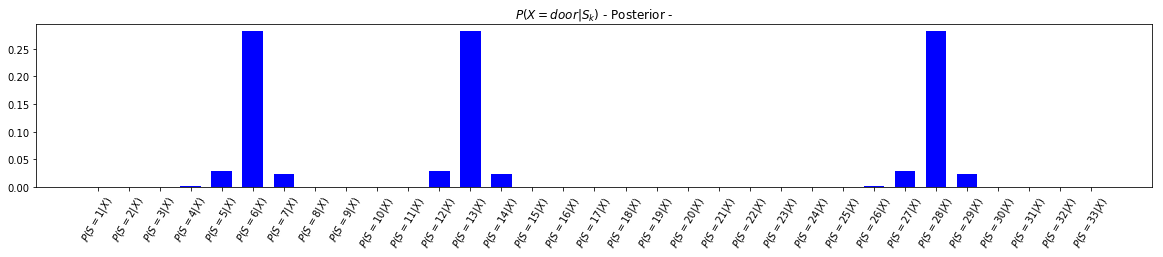

In [18]:
def run_filter(measurements, likelihood, prior = np.ones(N)/N):
    for i in range(len(measurements)):
        posterior = update(prior, measurements[i], likelihood)
        predicted = predict_perfect(posterior)
        prior = predicted
    return posterior
        
measurements = ['wall', 'wall', 'door', 'door', 'door', 'wall']
posterior = run_filter(measurements, likelihood, prior = np.ones(N)/N)
plot_distribution(posterior, title = '$P(X=door|S_k)$ - Posterior -', 
                             str_indexes= str_indexes_posterior, rotation = 60)

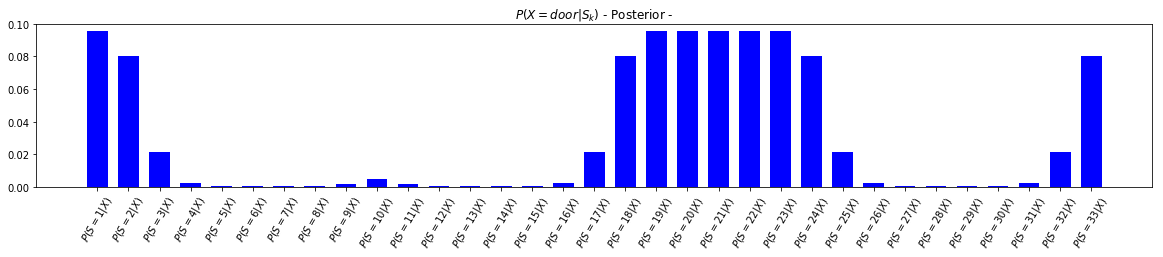

In [19]:
measurements = ['wall', 'wall', 'wall', 'wall', 'wall', 'wall']
posterior = run_filter(measurements, likelihood, prior = np.ones(N)/N)
plot_distribution(posterior, title = '$P(X=door|S_k)$ - Posterior -', 
                             str_indexes= str_indexes_posterior, rotation = 60)

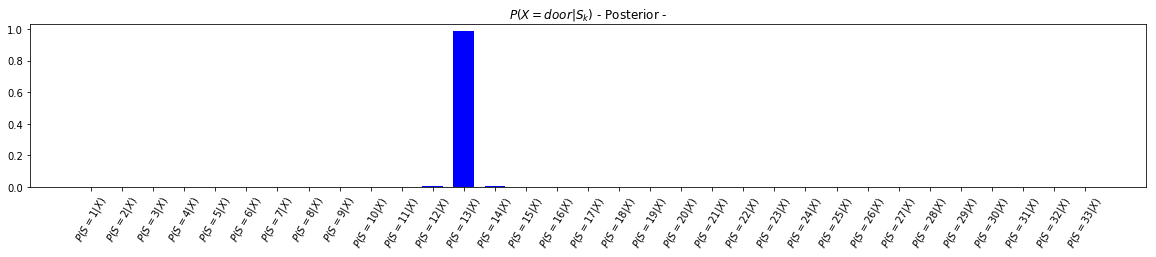

In [20]:
measurements = ['wall', 'wall', 'door', 'door', 'door', 'wall','wall','wall','wall','door', 'door', 
                'door', 'wall']
posterior = run_filter(measurements, likelihood, prior = np.ones(N)/N)
plot_distribution(posterior, title = '$P(X=door|S_k)$ - Posterior -', 
                             str_indexes= str_indexes_posterior, rotation = 60)

# Real Sensor and real walking Model 
## The model
$S_k = S_{k-1} + W$  (Prediction -> Sum of random variables)

$X_k$ and $S_k$ are correlated


**$P(X = $ "door" | $S =$ "infront door" $)$ $= 0.9$** and **$P(X = $ "wall" | $S =$ "infront door" $)$ $= 0.1$**

**$P(X = $ "door" | $S =$ "1 away from door" $)$ $ = 0.75$** and **$P(X = $ "wall" | $S =$ "1 away from door" $)$ $ = 0.25$**

**$P(X = $ "door" | $S =$ "2 away from door" $)$ $ = 0.2$** and **$P(X = $ "wall" | $S =$ "2 away from door" $)$ $ = 0.8$**

**$P(X = $ "door" | $S =$ "other" $)$ $ = 0.05$** and **$P(X = $ "wall" | $S =$ "other" $)$ $ = 0.95$**

$P(W=0) = 0.15$

$P(W=1) = 0.50$

$P(W=2) = 0.35$

## Generative model

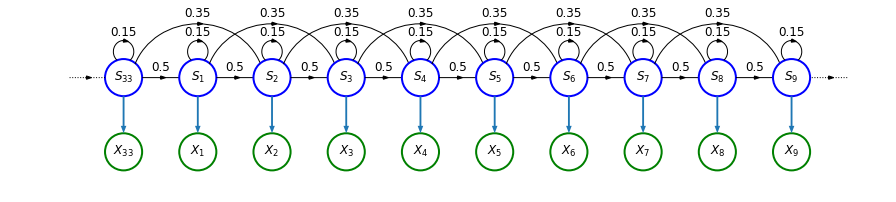

In [54]:
N = 33
W = np.zeros(N)
W[0] = 0.15
W[1] = 0.50
W[2] = 0.35
pulse = np.array([0.2, 0.75, 0.9, 0.75, 0.2])
doors = np.array([4, 11, 26])
noise = 0.05
hmm.plot_basic_hmm_model(N = 33, N_states_visible = 10, circular = True, stay_step_prob=W[0], 
                         one_step_prob= W[1], two_step_prob= W[2])

[ 0.36030303  0.48878788  0.15090909]


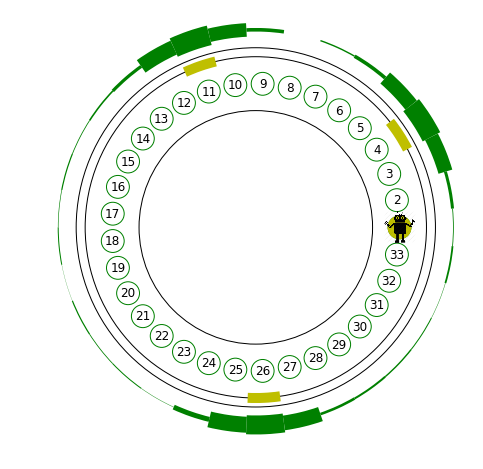

In [22]:
steps = 100*N
measurements, sample_stats, steps_stats, loc = generate_sample(likelihood, W, steps = steps)
print(steps_stats)
robot.plot_robot_room(loc = (steps%N)+1, N=N, doors = doors, sample_stats = sample_stats)

## Prediction with random transitions

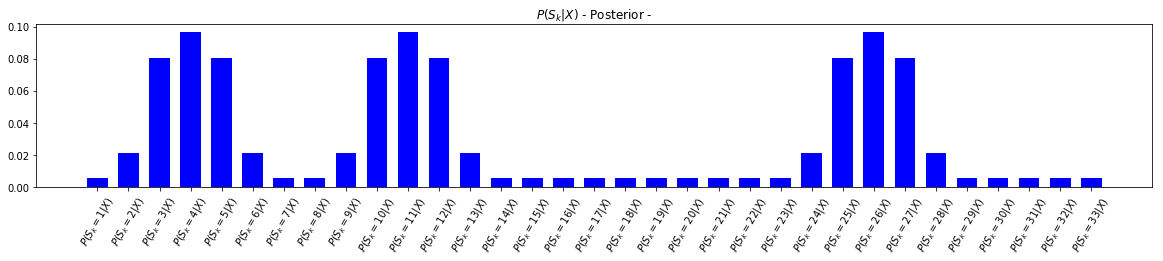

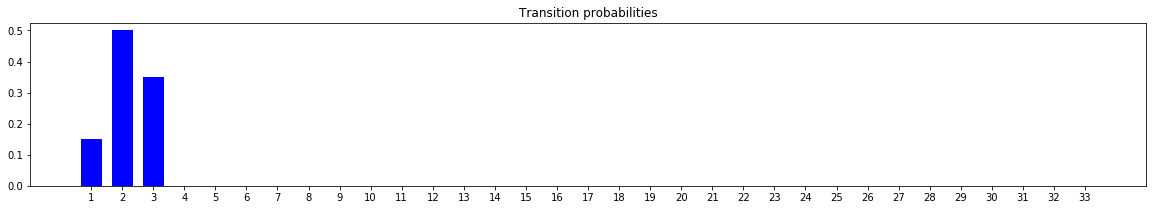

In [38]:
p = np.ones(N)/N
X = 'door'
likelihood = get_room_observation_likelihood(N = N, doors = doors, pulse = pulse, noise = noise)
posterior = update(p, X, likelihood)
str_indexes_posterior =  ['$P(S_k=%s|X)$'%int(i+1) for i in range(len(p))]
plot_distribution(posterior, title = '$P(S_k|X)$ - Posterior -', 
                             str_indexes= str_indexes_posterior, rotation = 60)
plot_distribution(W, title = 'Transition probabilities')

## Convolution

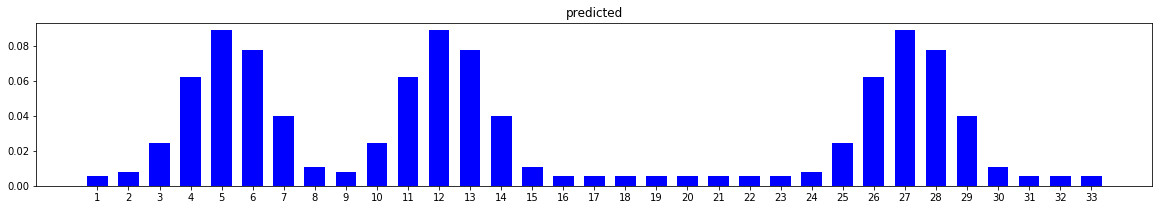

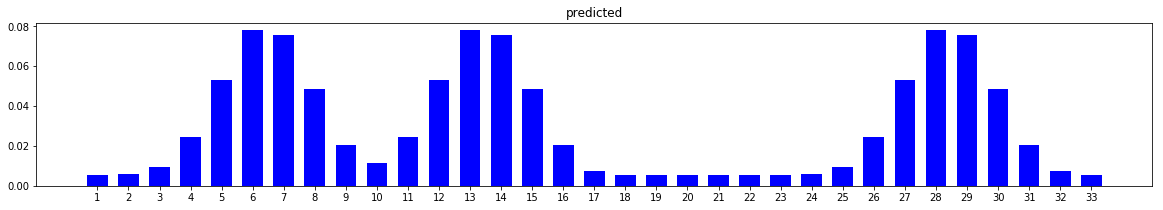

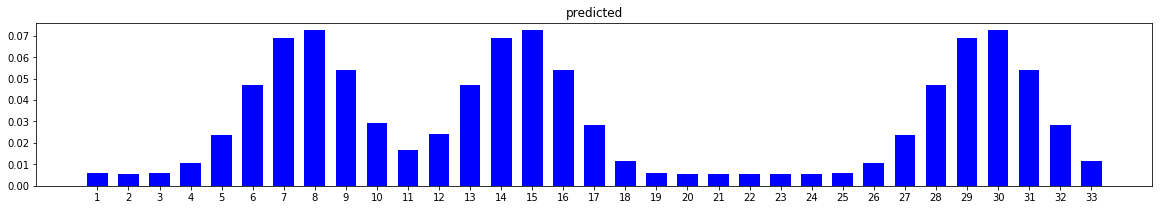

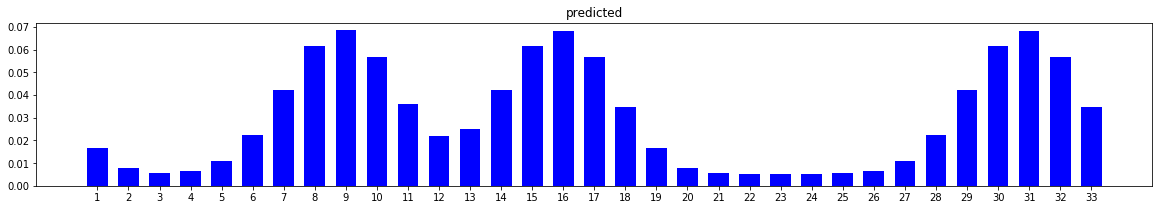

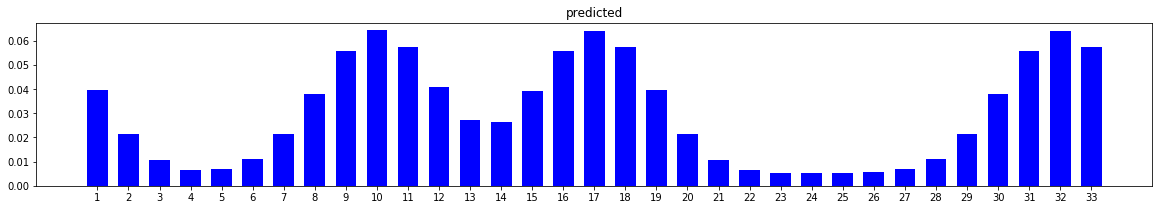

In [24]:
predicted = convolve(posterior, W)
plot_distribution(predicted, title = 'predicted')
predicted = convolve(predicted, W)
plot_distribution(predicted, title = 'predicted')
predicted = convolve(predicted, W)
plot_distribution(predicted, title = 'predicted')
predicted = convolve(predicted, W)
plot_distribution(predicted, title = 'predicted')
predicted = convolve(predicted, W)
plot_distribution(predicted, title = 'predicted')

## The histogram filter

In [25]:
def histogram_filter(W, measurements, likelihood, prior = np.ones(N)/N):
    for i in range(len(measurements)):
        posterior = update(prior, measurements[i], likelihood)
        mean, variance = get_hist_circular_mean_var(posterior)
        predicted = convolve(posterior, W)
        prior = predicted
    return posterior, predicted

## Animation

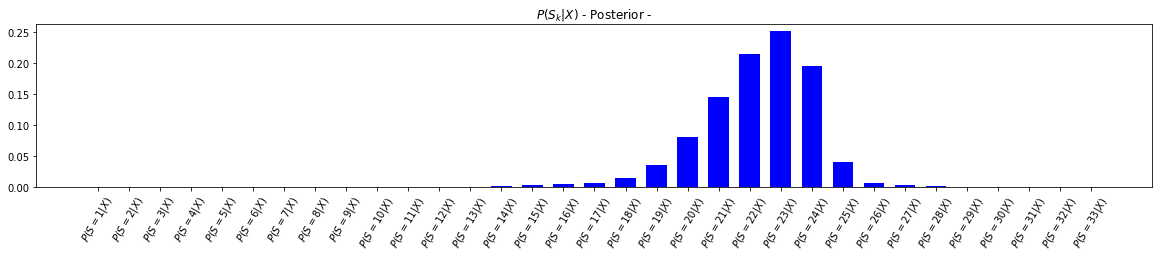

In [26]:
short_walk = ['wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 'door', 'wall']
cicle = ['wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 
         'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall',
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'door', 'door', 
         'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall', 
         'wall', 'wall', 'door', 'door', 'door', 'wall', 'wall', 'wall', 'wall', 'wall', 'wall']

#measurements = np.roll(cicle, -4)
#posterior = run_histogram_filter(W, measurements, prior = np.ones(N)/N)
#kalman.plot_distribution(posterior, title = '$P(S_k|X)$ - Posterior -', 
#                             str_indexes= str_indexes_posterior, rotation = 60)

for i in range(20):
    measurements = cicle[:(1*i+2)]
    
    posterior, _, _,_,_ = run_histogram_filter(W=W, measurements = measurements, likelihood = likelihood, prior = np.ones(N)/N)
    #plot_distribution(posterior, title = '$P(S_k|X)$ - Posterior -', str_indexes= str_indexes_posterior, rotation = 60)
    #display.clear_output(wait=True)
    #plt.gcf().show()
    #display.display(plt.gcf())
    #print(measurements)
    #input("Press ENTER to continue.")

plot_distribution(posterior, title = '$P(S_k|X)$ - Posterior -', str_indexes= str_indexes_posterior, rotation = 60)  

## Mean and variance vs iterations steps

### Perfect walking

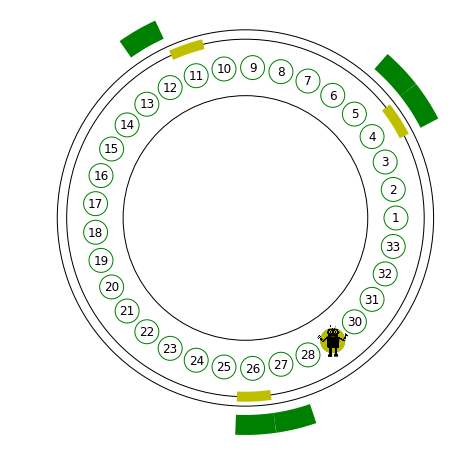

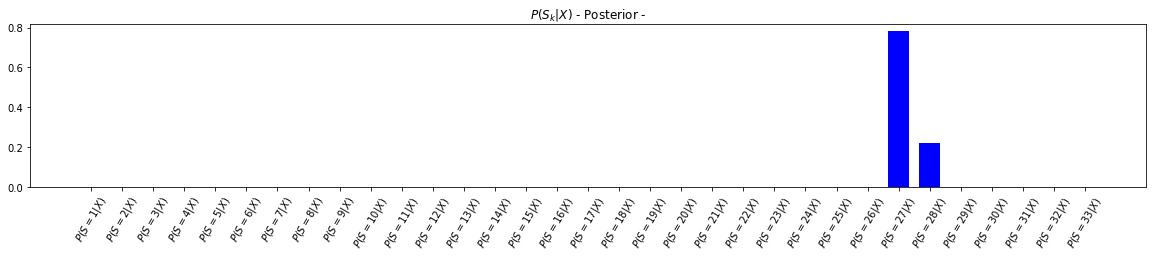

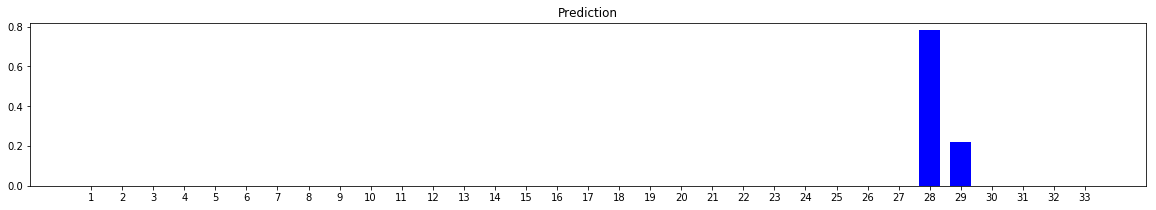

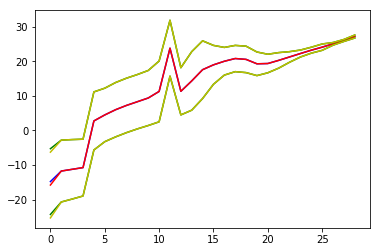

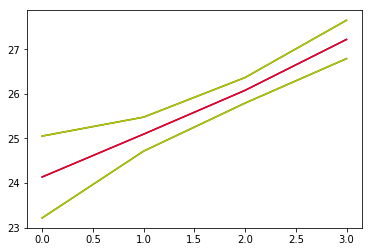

In [33]:
Wo = get_walking_noise_perfect_1(N)
#Wo = W
measurements, sample_stats, steps_stats, loc = generate_sample(likelihood, Wo, steps = steps)
robot.plot_robot_room(loc = loc, N=N, doors = doors, sample_stats = sample_stats)

posterior, mean_list, var_list, mean_list_pred, var_list_pred = run_histogram_filter(W=Wo, measurements = measurements, likelihood = likelihood, prior = np.ones(N)/N)
plot_distribution(posterior, title = '$P(S_k|X)$ - Posterior -', str_indexes= str_indexes_posterior, rotation = 60)
plt.show()
plot_distribution(convolve(posterior, Wo), title="Prediction")
plt.show()

plot_estimations(mean_list, var_list, mean_list_pred, var_list_pred)
plot_estimations(mean_list, var_list, mean_list_pred, var_list_pred, fr = 25)

### Real walking

[ 0.28888889  0.57777778  0.13333333]


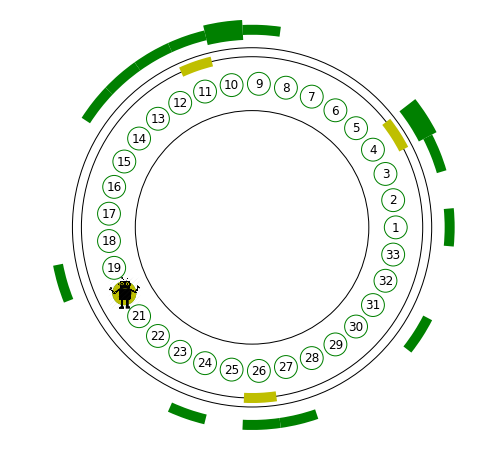

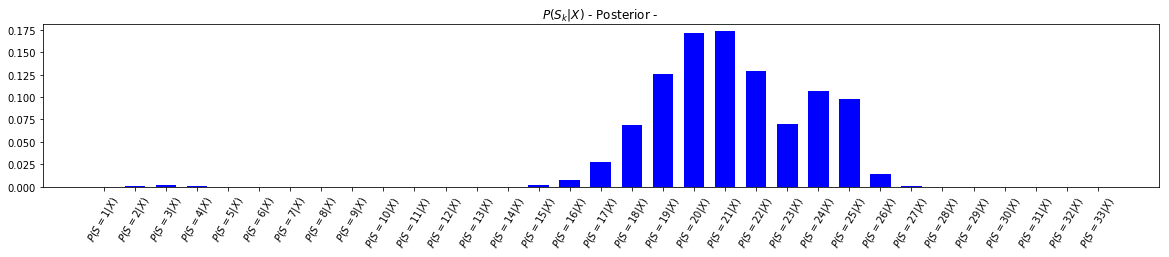

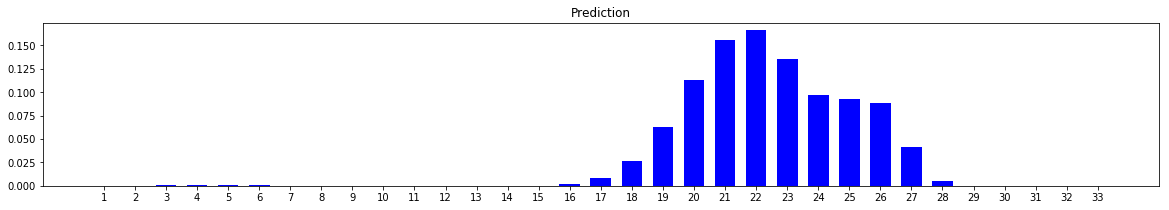

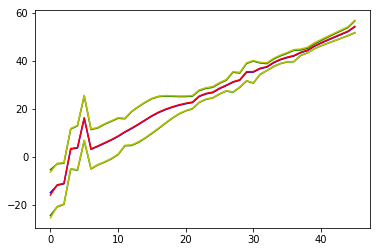

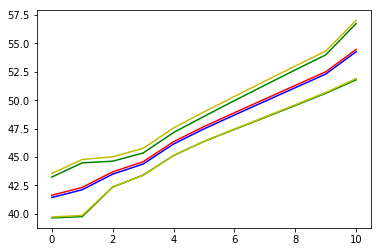

In [36]:
steps = 45
Wo = get_walking_noise_example_1(N)
measurements, sample_stats, steps_stats, loc = generate_sample(likelihood, Wo, steps = steps)
print(steps_stats)
robot.plot_robot_room(loc = loc, N=N, doors = doors, sample_stats = sample_stats)
posterior, mean_list, var_list, mean_list_pred, var_list_pred = run_histogram_filter(W=Wo, measurements = measurements, likelihood = likelihood, prior = np.ones(N)/N)
plot_distribution(posterior, title = '$P(S_k|X)$ - Posterior -', str_indexes= str_indexes_posterior, rotation = 60)
plt.show()
plot_distribution(convolve(posterior, Wo), title="Prediction")
plt.show()


plot_estimations(mean_list, var_list, mean_list_pred, var_list_pred)
plot_estimations(mean_list, var_list, mean_list_pred, var_list_pred, fr = steps-10)

### Play with parameters

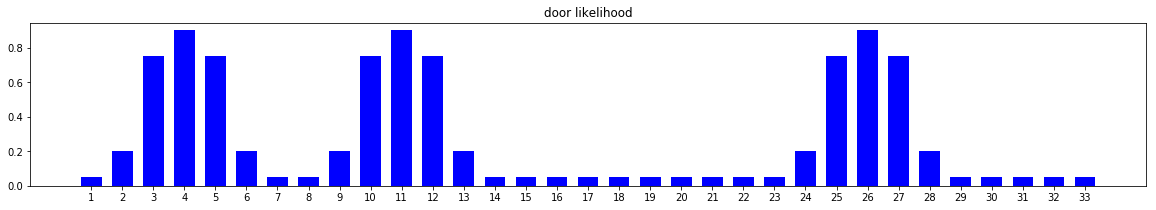

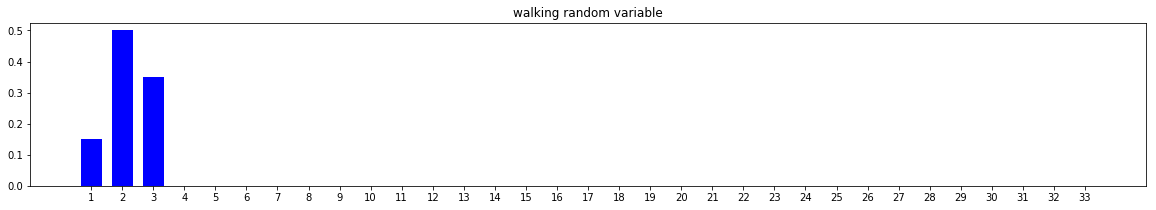

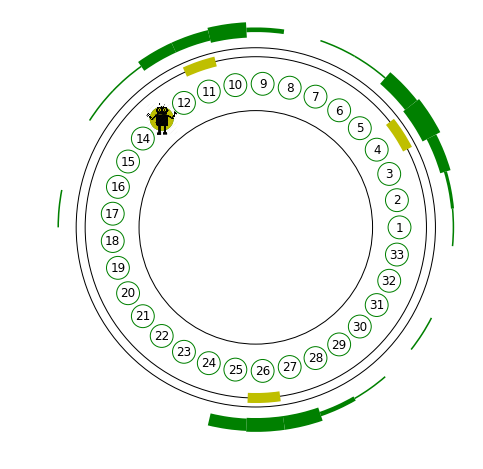

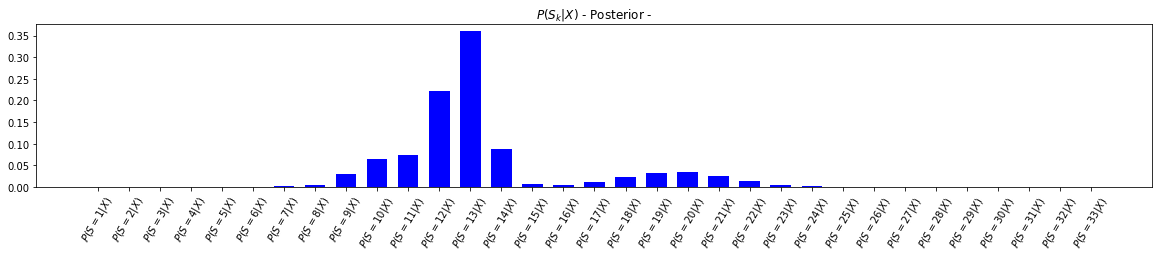

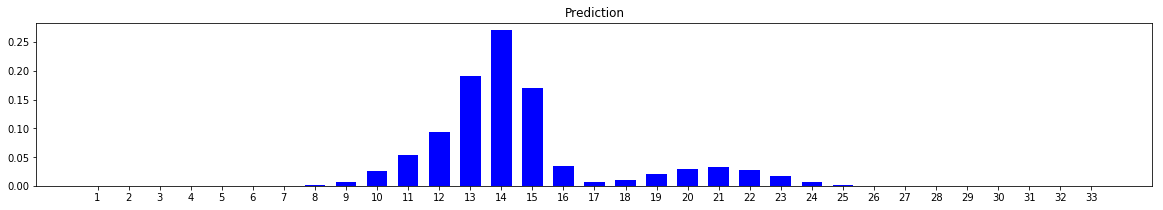

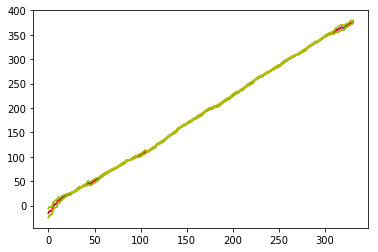

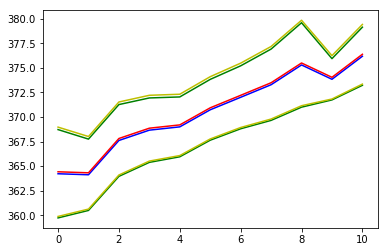

In [37]:
N= 33
steps = N*10
Wo = get_walking_noise_example_1(N)
pulse_t = np.array([0.2, 0.75, 0.9, 0.75, 0.2])
noise_t = 0.05
#pulse_t = np.array([0.01, 0.5, 0.9, 0.5, 0.01])
#noise_t = 0.005

likelihoodo = get_room_observation_likelihood(N = N, doors = doors, pulse = pulse_t, noise = noise_t)
plot_distribution(likelihoodo['door'], title = 'door likelihood')
plot_distribution(Wo, title = 'walking random variable')

measurements, sample_stats, steps_stats, loc = generate_sample(likelihoodo, W = Wo, steps = steps)

robot.plot_robot_room(loc = loc, N=N, doors = doors, sample_stats = sample_stats)

posterior, mean_list, var_list, mean_list_pred, var_list_pred\
= run_histogram_filter(W=Wo, measurements = measurements, likelihood = likelihoodo, prior = np.ones(N)/N)

plot_distribution(posterior, title = '$P(S_k|X)$ - Posterior -', str_indexes= str_indexes_posterior, rotation = 60)
plt.show()
plot_distribution(convolve(posterior, Wo), title="Prediction")
plt.show()


plot_estimations(mean_list, var_list, mean_list_pred, var_list_pred)
plot_estimations(mean_list, var_list, mean_list_pred, var_list_pred, fr = steps - 10)